# TNE 2: Principal Component Analysis

The purpose of this tutorial is to use Principal Component Analysis (PCA) 
for dimension reduction applied to images.


In [1]:
from pylab import *
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from numpy import linalg as la
from sklearn.utils.extmath import svd_flip
import warnings

## 1. Application: handwritten digits recognition 5 & 6
We load 2 matrices which contain each a sequence of examples of 16x16 images of handwritten digits which are 5 and 6 here. Each line of the matrix contains 256 pixel values coding for the gray level of a 16x16 image.

In [2]:
train_5 = np.loadtxt('train_5.txt', delimiter=',')   # 556 samples
train_6 = np.loadtxt('train_6.txt', delimiter=',')   # 664 samples

#### Examples of images:

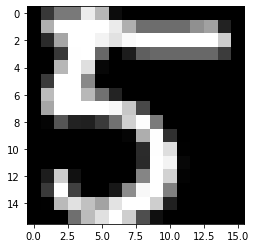

In [3]:
# Digit 5
n = 9;
I = np.reshape(train_5[n,:], (16,16))

plt.imshow(I, cmap='gray')
plt.show()

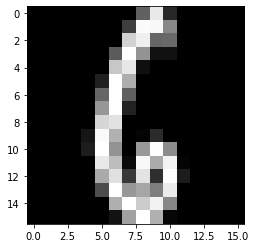

In [4]:
# Digit 6
n = 5;
I = reshape(train_6[n,:], (16,16))

plt.imshow(I, cmap='gray')
plt.show()

#### Separating the training and test sets

We keep in the training set the 145 first images of 5s and the 200 first
images of 6s:

In [5]:
x_train_brut = np.vstack((train_5[:145,:], train_6[:200,:]))
N_train = np.size(x_train_brut, axis=0)
class_train = np.ones((345, 1))   # label 1 for digit 6
class_train[:145] = 0       # label 0 for digit 5

x_test_brut = np.vstack((train_5[145:,:], train_6[200:,:]))
N_test = np.size(train_5, axis=0) + np.size(train_6, axis=0) - N_train
class_test = np.ones(train_5[145:, :].shape[0] + train_6[200:, :].shape[0])   # label 1 for digit 6
class_test[:train_5[145:, :].shape[0]] = 0       # label 0 for digit 5

In [6]:
x_train_brut, class_train = shuffle(x_train_brut, class_train, random_state=0)
x_test_brut, class_test = shuffle(x_test_brut, class_test, random_state=0)

## 2. Principal Component Analysis

The purpose of this part is to observe the respective contributions of
each component of a PCA of images of 5. The function `sklearn.decomposition.PCA` of `scikit-learn` is available. In practice, one must first estimate the mean vector and then work with centered data. 

### Documentation
First have a look at
http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
    

In [7]:
# Principal component analysis
moy_train = x_train_brut.mean(axis=0)  # all the data, 5 & 6
x_train_centre = x_train_brut - np.tile(moy_train,(N_train,1))

# PCA from scikit-learn
pca = PCA()
pca.fit(x_train_centre)  # you may forget centering that is done by sklearn PCA

singval = pca.singular_values_   # eigenvalues
comp = pca.components_           # principal components
proj = pca.transform(x_train_centre)  # computes the projection coefficients

### Display the averaged images of 5 & 6 respectively

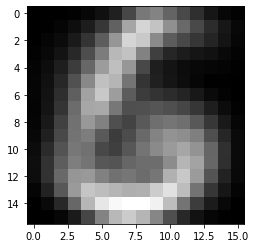

In [8]:
I_moy = np.reshape(moy_train, (16, 16))   # averaged image = mean 
plt.imshow(I_moy, cmap = 'gray')
plt.show()

### Display an example rebuilt from the 1st component only

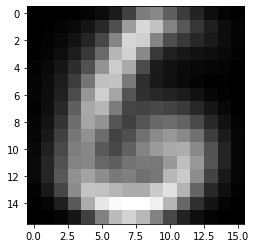

In [9]:
n=12   # choice of image no n=12 or any other

I = I_moy + proj[n,0]*np.reshape(comp[0,:],(16,16))  # adding the 1st PCA component 
plt.imshow(I,cmap='gray')
plt.show()

# Calculate the principal components using numpy

### Singular Value Decomposition.

In [10]:
U, S, Vt = la.svd(x_train_centre, full_matrices=False)

# flip eigenvectors' sign to enforce deterministic output
U, Vt = svd_flip(U, Vt)
proj_np = x_train_centre.dot(Vt.T)

Using the np.linalg.svd function, we got V which is the matrix of eigenvectors (each column is an eigenvector) and S is a diagonal matrix with eigenvalues $\lambda_{i}$ in the decreasing order on the diagonal.

The j-th principal component is given by j-th column of $X.V$

In [11]:
print("are sinval from sklearn.PCA and S very close ? ", np.allclose(S, singval))
print("are proj from sklearn.PCA and proj_np very close ? ", np.allclose(proj, proj_np))

are sinval from sklearn.PCA and S very close ?  True
are proj from sklearn.PCA and proj_np very close ?  True


### Exercise 1: PCA & approximation

1. Read the documentation of function `PCA` and identify the input and output parameters.
2. Implement a progressive reconstruction of an image of digit 5 by adding the successive 
contribution of principal components.
3. Observe graphical results. How many components are necessary to obtain a 
reconstruction that you may consider as acceptable? nice? very nice?
4. Optional question: do the same for 6.
------------------


__Question 1__

**Inputs of the class**: 
* **Number of components**: The dimension of the new space, where the data is going to be projected. By default, it is the minimum value of the number of samples n, and the number of features D.
    * of n_components = "mle" it uses Minka's MLE for an automatic choice of dimensionality (the solver would be full, c.f solver), but it can be specified as a float (especially useful in a gridSearch)
    * if it's a float in the interval (0, 1) (and solver = full): it acts as the threshold of variance explained by the components
* **solver**: the solver used for Singular Value Decomposition of the data:
    * when = *full*: it runs a linear algebra solver for the SVD using all the data

    * when = *randomized*: it used the PCA algorithm introduced by Halko et al. [ref], where it approximates the matrix Q such that: $A = Q Q^T A$, Q containing fewer columns than our data matrix A, it facilitates the computation of the matrices U and V since the problem is reduced to the matrix $Q^T A$. They construct a matrix formed by randomly selected obersvations and orthonormalize its vectors (columns) to get the matrix $Q$. We may need to set the input parameters for the number of iterations and the number of random vector: **iterated_power** and **n_oversamples**

    * when = *arpack*: the solver used hers is from sparse.linalg.svd but requires the number of components to be strictly lower than the smallest dimension of the data

    * if *auto*:  for data larger 500x500 in dimensions and the number of components is lower than 80% of the smallest dimension of the data, then it uses *randomized* method, else the *full* solver is used.

* **copy**: whether or not to overwrite the input matrix (False = overwrite)
* **whiten**: preprocessing step to make the input data less redundant (especially adjacent pixels in an image), i.e the feature less correlated: a covariance matrix = Identity 
* **random_state** : for reproducible results, used for the solver *randomized* and *arpack*

**Attributes of the class**
* **components_**: ndarray of shape (n_components, n_features)

* **explained_variance_**: ndarray of shape (n_components,)
The amount of variance explained by each of the selected components. The variance estimation uses n_samples - 1 degrees of freedom.
* **explained_variance_ratio_n**: darray of shape (n_components,)
Percentage of variance explained by each of the selected components.

* **singular_values_n**: darray of shape (n_components,)
The singular values corresponding to each of the selected components. T

* **mean_n**: darray of shape (n_features,)
X.mean(axis=0).

* **n_components_**: int
The estimated number of components. When n_components is set to ‘mle’ or a number in (0,1) (with svd_solver == ‘full’) this number is estimated from input data.  If n_components is None, it is the lesser value of n_features and n_samples, otherwise it's the parameter n_components.

* **n_features_**: int: number of features

* **n_samples_**: int: number of samples of the data set

* **noise_variance_**: float
The estimated noise covariance 

* **n_features_in_**: int
Number of features seen during fit.

* **feature_names_in_**: ndarray of shape (n_features_in_,)
Names of features seen during fit (array of string), particularly useful for feature importance


In [12]:
nstepplot = 32
nplot_per_row = 4
n_rows = pca.n_components_ //(nstepplot*nplot_per_row)

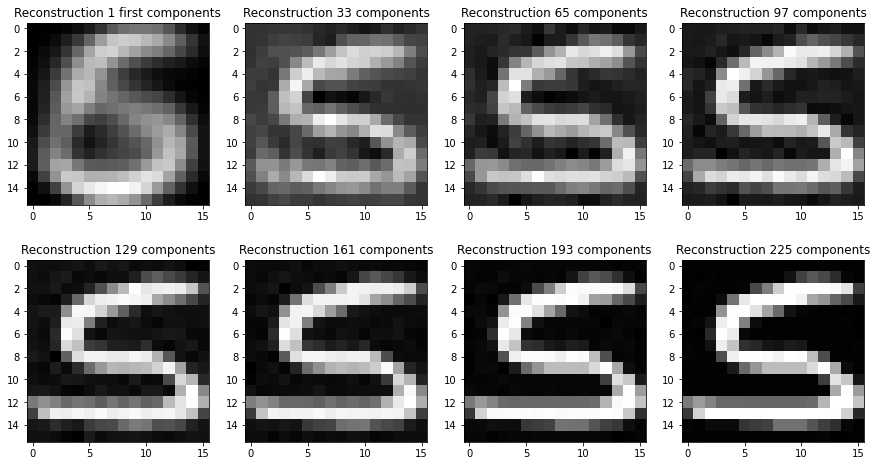

In [13]:
fig, ax = plt.subplots(n_rows, nplot_per_row)

fig.set_facecolor("white")
fig.set_figheight(8)
fig.set_figwidth(15)
def plot_per_comp(i, n_sample=200):
    I_temp = I
    if i==0:
        I_temp = I_moy + np.reshape(proj[n_sample, 0]* comp[0, :], (16, 16))
        ax[0, 0].set_title(f"Reconstruction {i+1} first components")
        ax[0, 0].imshow(I_temp, cmap='gray')
    if (i>=nstepplot) and (i%nstepplot==0):  
        plotpos = i//nstepplot 
        plotrow =  plotpos//nplot_per_row 
        plotpos -= plotrow*nplot_per_row
        I_temp = I_moy + np.reshape(np.reshape(proj[n_sample, :i+1], (1, i+1)).dot(comp[:i+1, :]), (16, 16))
        ax[plotrow, plotpos].set_title(f"Reconstruction {i+1} components")
        ax[plotrow, plotpos].imshow(I_temp, cmap='gray')

    
projection = np.vectorize(plot_per_comp)
components_range = np.arange(pca.n_components_, dtype=int)
projection(components_range)
plt.show()


We can see that using only one component gives most information, but it is not enough. In this example, the 5 looks a lot like a 6 digit, and only by adding more information (more components), did we begin to notice the difference. However, we can use only 65 (or go up to 97) components, as the reconstruction highlights well the digit and the boundares if the important pixels. We can also plot the explained variance to visualize this aspect:

In [14]:
pca.explained_variance_ratio_.shape

(256,)

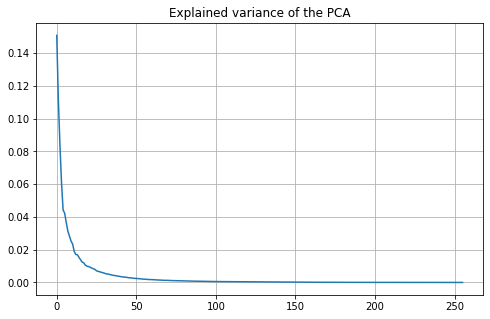

In [15]:
plt.figure(figsize=(8, 5), facecolor="white")

plt.plot(pca.explained_variance_ratio_)
plt.grid()
plt.title("Explained variance of the PCA")
plt.show()

This plot confirms our analysis, as the explained variance drops drastically to zero at 100 components. We don't need a model that explains 100% of the data (as it might also include the noise), so we can continue we a value between 20 and 50 components. In this problem, it is normal not to need many components, as most pixels in the image are not very relevant to the classification (as we have seen in the last session).

We can also use cumulative explained variance to visualize this aspect. at 50, we have already surpassed the 90% of explained variance. The proportion of variance is chosen depending on the application. For descriptive purposes, we might only need 80% of the data or less (corresponding to 20 components). Social sciences established a threshold of 60%, but since there is no rule of thumb, we have to consider the model we are using (LDA for instance would fail with many features) then fine-tune it with regards to the task we are applying it to.

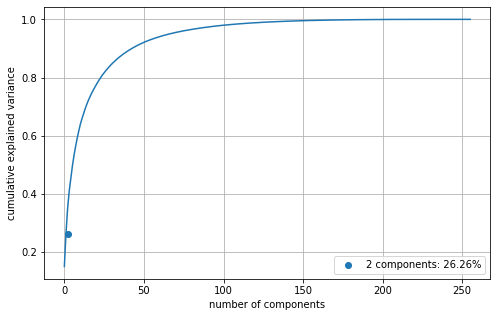

In [16]:
plt.figure(figsize=(8, 5), facecolor="white")

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.scatter(2, np.cumsum(pca.explained_variance_ratio_)[1], label=f"2 components: {np.round(np.cumsum(pca.explained_variance_ratio_)[1], 4)*100}%")
plt.grid()

plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.legend()
plt.show()

This plot confirms our analysis, by choosing between 20 and 50 components, we have an important cumulative explained variance (between 0.8 and 0.9) so we have kept the most important components that allow the model to distinguish between 5 and 6. and if we reconstruct the data using just the largest subset of principal components, we are preferentially keeping the signal and throwing out the noise.

We will now implement the same algorithm for an instance of the 6 digit:

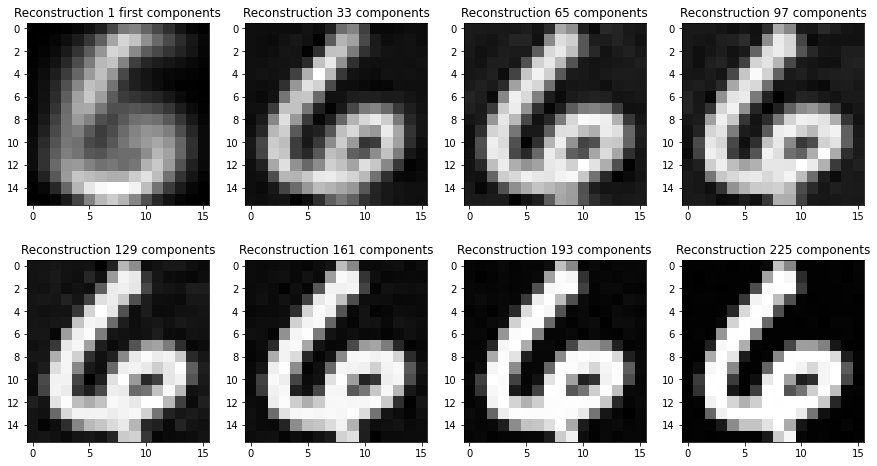

In [17]:
# set figure and e=axes for this example
fig, ax = plt.subplots(n_rows, nplot_per_row)
fig.set_facecolor("white")
fig.set_figheight(8)
fig.set_figwidth(15)

    
# apply it to the 6 digit
n_6 = np.random.choice(np.where(class_train==1)[0])
projection(components_range, n_sample=n_6)
plt.show()


30 components were enough to reconstruct faithfully the digit 6 as we have seen in the explained variance plot as well. Using only one component, we can see that the overall structure of the digit is restored but we wouldn't be able to differentiate between a 6 and a 5 with only this information.

### Exercise 2: PCA & classification
1. Use `proj[0:2,:]` as the coordinates of a point representing each sample
of the training set in a plane. Display the cloud of points associated to
digits 5 and 6 by using 2 different colors.
2. Comment on the repartition of points in the plane. 
3. Do you see how this PCA step makes possible the use of a much simpler classification? 
What would you propose as an alternative to logistic regression of TP3 then?


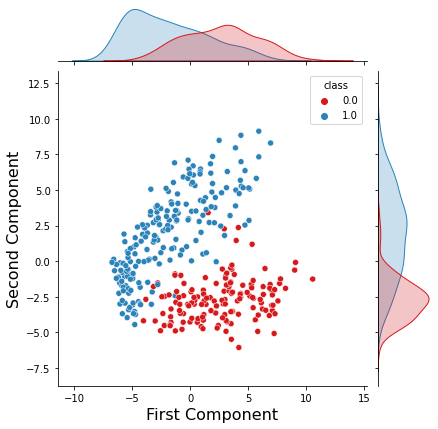

In [18]:
import pandas as pd
data=pd.DataFrame(np.hstack((proj[:, :2], class_train.astype(int))), columns=["Component1", "Component2", "class"])
# data = pd.DataFrame({"Component1": proj[:, 0], "Component2": proj[:, 1], "class": class_train.flatten()}.items())
ax = sns.jointplot(data=data, x="Component1", y="Component2", hue="class", palette={
    0.0: '#d7191c',
    1.0: '#2b83ba'
})
ax.set_axis_labels('First Component', 'Second Component', fontsize=16)

plt.show()

When we visualise the first two components, we can see clearly that the variance of the first component is more important than the second component: 

- The points of the first component are fairly distributed between -7.5 and 3 and less distributed otherwise
- The points of the second component are centred between -4 and -2.

The two destribution are quit close to the normal distribution especially the second component.

We can see that the two classes can be easily distinguished when using only the first two components. Like we said before, one component is not enough to distinguish a 5 from a 6. However, here our aim is not to reconstruct the image but only to extract features from it and 2 components can be a parcimious solution for the problem (as we go from 256 features to 2). 

As we can notice that the distribution of the points is not far from a normal distribution, we might consider an LDA or QDA model, although a FDA might be better suited for this case as we are sure the normal distribution hypothesis holds. The distributions are not identical between the classes, sp we expect the QDA to work better than the LDA model. 

In [19]:
lda = LinearDiscriminantAnalysis()
lda.fit(proj[:, :2], class_train[:, 0])
x_test_centre = x_test_brut-np.tile(moy_train,(N_test,1)) # we can not use the mean of the test
proj_test = pca.transform(x_test_centre)  # computes the projection coefficients
print("train error with LDA on 2 components: ", round(1 - lda.score(proj[:, :2], class_train[:, 0]), 4))
print("test error with LDA on 2 compoenents: ", round(1 - lda.score(proj_test[:, :2], class_test), 4))

train error with LDA on 2 components:  0.0435
test error with LDA on 2 compoenents:  0.048


In [20]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(proj[:, :2], class_train[:,0])
x_test_centre = x_test_brut-np.tile(moy_train,(N_test,1)) # we can not use the mean of the test set.
proj_test = pca.transform(x_test_centre)  # computes the projection coefficients
print("train error with QDA on 2 components: ", round(1 - qda.score(proj[:, :2], class_train[:,0]), 4))
print("test error with QDA on 2 components: ", round(1 - qda.score(proj_test[:, :2], class_test), 4))

train error with QDA on 2 components:  0.0319
test error with QDA on 2 components:  0.0331


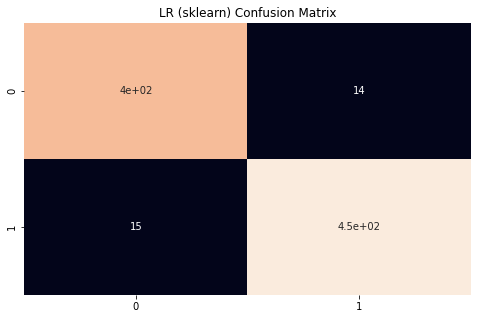

In [21]:
predictions = qda.predict(proj_test[:, :2])
cm = confusion_matrix(predictions, class_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("LR (sklearn) Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

The results improved compared to our best fine-tuned model Logistic regression of the last work (0.033 error vs 0.037), even without the FDA. So we can use a quadratic dicriminant analysis instead of Logistic regression for this classification task. It is important to note that without the dimensionality reduction, it would not have been possible for us to use a simple model like LDA or QDA as they are known to fail on highly dimensional problems (and we had 256 features). Therefore, the FDA (or for now PCA) step is essential.

From the way we created our train/test sets (without a random train test split) we are sure that all models had the same instances for training, and the same test set is given to all of them. The order is different as we shuffled the data in both works.

#### Pixel importance in the PCA decomposition
We can also visualize which pixels were more important than the other for the first two components used for the PCA

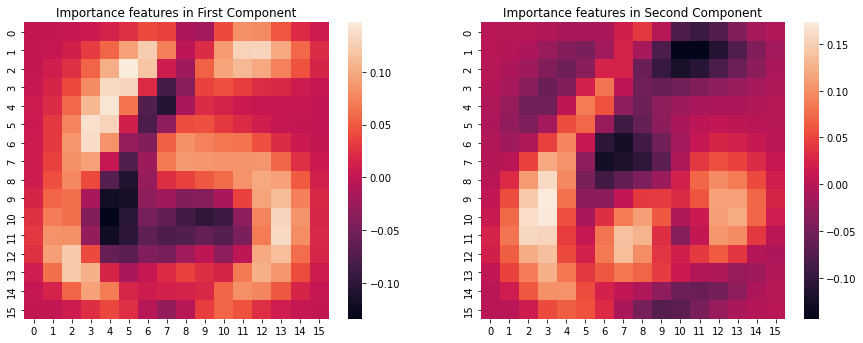

In [22]:
Importance = np.zeros(x_train_brut.shape[1])
Importance_2 = np.zeros(x_train_brut.shape[1])

Importance = comp[0]
Importance = Importance.reshape((16, 16))
Importance_2 = comp[1]
Importance_2 = Importance_2.reshape((16, 16))
plt.figure(figsize=(15, 12),facecolor="white")
plt.subplot(2, 2, 1)
sns.heatmap(Importance)
plt.title("Importance features in First Component")

plt.subplot(2, 2, 2)
sns.heatmap(Importance_2)
plt.title("Importance features in Second Component")
plt.show()

The plots above highlights the parts that we usually look at to differentiate a digit 5 from a digit 6, so it should be able to extract well the features from the images. It is normal that the important pixels for one components are not for the other one as the two vectors are orthogonal in the reduced space.

#### What if we used more than two components in the LDA and QDA?

We tried applying LDA and QDA on the first two components and we got better results than the logisitic regression, but we have seen in the explained variance plot that only 2 components can not explain entirely our data. Although we don't have to explain 100% as this will likely get us to overfit , but we don't want to underfit either. Here we will apply the QDA and LDA models on 25 components. We are therefore still not in a highly dimensional problem:

In [23]:
from sklearn.model_selection import train_test_split

X_train_t, X_val, class_train_t, class_val = train_test_split(x_train_centre, class_train, test_size=0.25, random_state=15)
pca_exp = PCA()
qda = QuadraticDiscriminantAnalysis()
E = []
n_comp_list = np.linspace(2, 50, 10, dtype=int)
for i in n_comp_list:
    pca_exp.fit(X_train_t)
    proj_exp = pca.transform(X_train_t) 
    proj_val_exp = pca.transform(X_val) 
    qda.fit(proj_exp[:, :i], class_train_t[:,0])
    E.append(qda.score(proj_val_exp[:, :i], class_val))

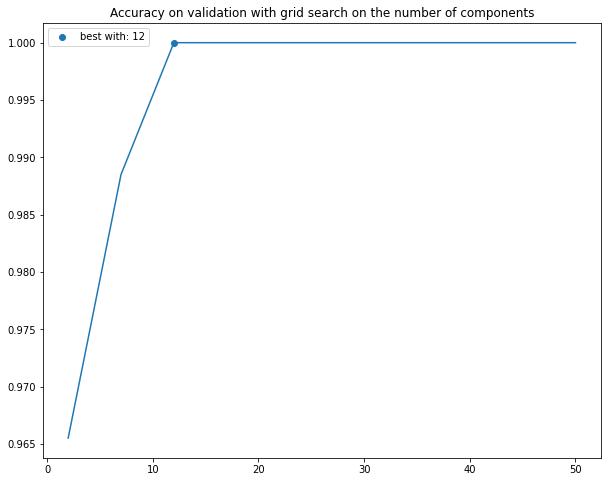

In [24]:
plt.figure(figsize=(10, 8), facecolor="white")
plt.plot(n_comp_list, np.array(E))
plt.scatter(n_comp_list[np.argmax(E)], np.max(E), label=f"best with: {n_comp_list[np.argmax(E)]}")
plt.title("Accuracy on validation with grid search on the number of components")
plt.legend()
plt.show()

We can see that 12 components works better than the first case, we noticed that results fluctuated at each execution because we hadn't set a random state, but we maybe should also implement a cross validation instead of only the grid search and we would make use of all the data. We will know get the results with 12 components:

In [25]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(proj[:, :12], class_train[:,0])
x_test_centre = x_test_brut-np.tile(moy_train,(N_test,1)) # we can not use the mean of the test set.
proj_test = pca.transform(x_test_centre)  # computes the projection coefficients
print("train error with QDA on 12 components: ", round(1 - qda.score(proj[:, :12], class_train[:,0]), 4))
print("test error with QDA on 12 components: ", round(1 - qda.score(proj_test[:, :12], class_test), 4))

train error with QDA on 12 components:  0.0116
test error with QDA on 12 components:  0.016


Indeed, with 12 components we get an error rate considerably lower than the one we had with 2 components and with logistic regression. In the last work, we raised a point about having 0 as training error even after regularization, here our training error is greater than 0, but the test error is around the same value so we can conclude we are not overfitting.

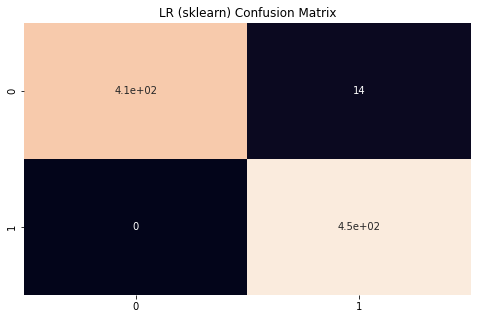

In [26]:
predictions = qda.predict(proj_test[:, :12])
cm = confusion_matrix(predictions, class_test)
tn, fp, fn, tp = cm.ravel()
plt.figure(figsize=(8, 5), facecolor='white')
plt.title("LR (sklearn) Confusion Matrix")
sns.heatmap(cm, annot=True, cbar=False)
plt.show()

In [27]:
accuracy_QDA = (tp + tn) / (tp + tn + fp + fn)
precision_QDA = tp / (tp + fp)
recall_QDA = tp / (tp + fn)
F1_QDA = 2 * (precision_QDA * recall_QDA) / (precision_QDA + recall_QDA)
mcc_QDA = (tp*tn - fp*fn)/ sqrt((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))
print(f"The accuracy of QDA = {round(accuracy_QDA, 4)}")
print(f"The precision of QDA = {round(precision_QDA, 4)}")
print(f"The recall of QDA = {round(recall_QDA, 4)}")
print(f"The F1 of QDA = {round(F1_QDA, 4)}")
print(f"The MCC score of QDA = {round(mcc_QDA, 4)}")

The accuracy of QDA = 0.984
The precision of QDA = 0.9698
The recall of QDA = 1.0
The F1 of QDA = 0.9847
The MCC score of QDA = 0.9684


The model was able to classify better the digit 6 (recall = 1), maybe the components contained more information about this class than the other.

## Beyong this lab

Have a look at other examples of applications, like

http://scikit-learn.org/stable/auto_examples/decomposition/plot_faces_decomposition.html#sphx-glr-auto-examples-decomposition-plot-faces-decomposition-py
    

In [28]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

In [30]:
import os

os.system('jupyter nbconvert --to html TP4_MAKHLOUF_MAKNI.ipynb')

0